<a href="https://colab.research.google.com/github/rtrochepy/astronomer/blob/main/best_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importar Librerías

In [1]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, f1_score, balanced_accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from joblib import dump, load
from scipy.stats import skew, kurtosis
from imblearn.over_sampling import ADASYN
from imblearn.combine import SMOTEENN
import os
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import numpy as np

## Leer el Dataset

El primer paso consiste en cargar el conjunto de datos en el entorno de trabajo para su análisis y preprocesamiento.

In [2]:
# Ignorar advertencias de pandas para una ejecución más limpia
warnings.filterwarnings('ignore')

# Configuración de pandas para mostrar todas las columnas al imprimir
pd.set_option('display.max_columns', None)

In [3]:
# Lee el archivo CSV.  Error handling mejorado.
try:
    df = pd.read_csv("test_data.csv")
except FileNotFoundError:
    print("Error: El archivo 'data_labels.csv' no se encuentra.")
except pd.errors.EmptyDataError:
    print("Error: El archivo 'data_labels.csv' está vacío.")
except pd.errors.ParserError:
    print("Error: Error al analizar el archivo 'data_labels.csv'.")

In [4]:
# ver cuantas filas y columnas tiene (90009 filas, 191 columnas)
df.shape

(60307, 190)

In [5]:
print(f"Filas cargadas: {len(df)}")

Filas cargadas: 60307


In [6]:
# Mostrar las primeras filas y la forma inicial del DataFrame
print("Primeras filas del DataFrame:")
print(df.head())
print("\nDimensiones del DataFrame (filas, columnas):", df.shape)

Primeras filas del DataFrame:
                                                  ID Expenditure_AHF  \
0  3333333702723732807074333342320276353770732523...      2017-03-15   
1  3333333702723732807074333342320276353770732523...      2017-04-13   
2  3333333702723732807074333342320276353770732523...      2017-06-03   
3  3333333702723732807074333342320276353770732523...      2017-06-19   
4  3333333702723732807074333342320276353770732523...      2017-07-22   

   Payment_6804  Infraction_CGP  Base_7744  Base_80863  Risk_1930  \
0      0.938469        0.001733   0.008724    1.006838   0.009228   
1      0.936665        0.005775   0.004923    1.000653   0.006151   
2      0.954180        0.091505   0.021655    1.009672   0.006815   
3      0.960384        0.002455   0.013683    1.002700   0.001373   
4      0.947248        0.002483   0.015193    1.000727   0.007605   

   Expenditure_JIG  Infraction_SNZ  Base_02683  Infraction_SBF  \
0         0.124035        0.008771    0.004709          

## Tratamiento de Valores Nulos (Missing Values)

In [7]:
# Ver los nulos que hay en cada columna
nulos_por_columna = df.isnull().sum()

# Filtrar solo las columnas que tienen valores nulos
nulos_por_columna = nulos_por_columna[nulos_por_columna > 0]
nulos_por_columna

,0
Payment_6804,399
Base_80863,15
Expenditure_JIG,11632
Infraction_SNZ,15
Base_02683,15
...,...
Infraction_QGR,968
Infraction_ZTLC,49935
Infraction_LSX,968
Infraction_IBJ,413


### Eliminación de Columnas con Más del 50% de Valores Nulos

- Las columnas con más del 50% de valores nulos se eliminan del dataset, ya que estimar una gran cantidad de datos faltantes puede distorsionar significativamente los resultados.

In [8]:
# Calcula el umbral para filtrar las columnas
umbral = 0.5 * df.shape[0]

# Elimina las columnas con más del 50% de valores faltantes
df = df.dropna(thresh=umbral, axis=1)
df

,ID,Expenditure_AHF,Payment_6804,Infraction_CGP,Base_7744,Base_80863,Risk_1930,Expenditure_JIG,Infraction_SNZ,Base_02683,Infraction_ZWWJ,Infraction_QJJF,Base_76065,Infraction_EJZ,Base_6872,Risk_0322,Infraction_FMXQ,Infraction_GGO,Infraction_TLPJ,Base_1165,Base_39598,Base_6187,Infraction_ZTNC,Base_85131,Risk_9995,Infraction_AYWV,Payment_22507,Base_9516,Expenditure_YTR,Base_36384,Expenditure_FIP,Infraction_PAS,Risk_0003,Expenditure_HMO,Base_24406,Expenditure_LMSR,Infraction_BSU,Base_14808,Risk_8065,Infraction_ZYW,Base_1039,Infraction_HSSU,Infraction_EHZP,Infraction_TBP,Base_0580,Expenditure_RGD,Infraction_PBC,Infraction_YFSG,Infraction_DQLY,Infraction_AQO,Base_0229,Base_69608,Base_91828,Base_6852,Infraction_CLH,Expenditure_IDZ,Risk_1475,Expenditure_BWX,Base_8511,Infraction_JYZB,Base_22178,Infraction_ZTYG,Infraction_ZVW,Infraction_EYU,Expenditure_UWVG,Base_3041,Payment_3207,Infraction_QKZN,Infraction_CZE,Base_65352,Risk_7095,Infraction_JBR,Base_66195,Base_36516,Infraction_RXQH,Infraction_HFU,Risk_6346,Expenditure_HRQ,Infraction_VTR,Risk_2102,Risk_4804,Base_7331,Infraction_XWX,Expenditure_XDD,Risk_4553,Base_67585,Risk_8742,Infraction_VHU,Risk_4247,Risk_2380,Infraction_GSS,Risk_0454,Base_8730,Expenditure_HKXV,Infraction_MHM,Risk_4160,Risk_3506,Base_23737,Expenditure_GCAO,Risk_9367,Base_7910,Expenditure_GMC,Risk_9423,Risk_6977,Base_9103,Infraction_KSBR,Risk_6178,Risk_6197,Infraction_NRBQ,Infraction_WVC,Infraction_QVSL,Infraction_QXUM,Risk_8532,Risk_9247,Infraction_IMIM,Expenditure_UIWS,Expenditure_ONEG,Expenditure_MTRQ,Expenditure_LAHK,Expenditure_HPM,Infraction_LTIS,Infraction_HFSI,Infraction_ETH,Infraction_SDWM,Base_5441,Base_2810,Risk_8902,Base_67254,Infraction_PTY,Infraction_BGGU,Base_4569,Expenditure_BEH,Infraction_LMHK,Infraction_NMCB,Infraction_TPAF,Infraction_ZRH,Infraction_TEN,Infraction_XEPQ,Infraction_ZMKI,Infraction_WIS,Infraction_RKTA,Infraction_IIZ,Infraction_WVAW,Infraction_KEJT,Infraction_TFOY,Infraction_WMAQ,Infraction_SIA,Infraction_CZXL,Infraction_QEY,Base_52892,Infraction_HUK,Infraction_VHHP,Infraction_LIES,Risk_5270,Infraction_QWWW,Infraction_YQXM,Infraction_QGR,Infraction_LSX,Infraction_IBJ,Infraction_DNOU
0,3333333702723732807074333342320276353770732523...,2017-03-15,0.938469,0.001733,0.008724,1.006838,0.009228,0.124035,0.008771,0.004709,NaN,0.000630,0.080986,0.708906,0.170600,0.006204,0.358587,0.525351,0.255736,0.063902,0.059416,0.006466,1.335856,0.008207,0.001423,0.207334,0.736463,0.096219,0.023381,0.002768,0.008322,1.001519,0.008298,0.161345,0.148266,0.922998,0.354596,0.118075,0.001882,0.158612,0.018385,0.063646,0.199617,0.308233,0.016361,0.401619,0.091071,CR,O,0.007126,0.007665,0.652984,0.008520,0.004730,very_high,0.272008,0.008363,0.515222,0.002644,0.009013,0.004808,0.008342,0.119403,0.004802,0.108271,0.050882,0.007554,0.080422,0.069067,0.004327,0.007562,NaN,0.007729,0.000272,0.001576,0.004239,0.001434,0.002271,0.004061,0.007121,0.002456,0.002310,0.003532,0.008033,1.009825,0.084683,0.003820,0.007043,0.000438,0.006452,0.000830,0.005055,0.0,0.005720,0.007084,0.000198,0.008907,1,0.002537,0.005177,0.006626,0.009705,0.007782,0.002450,1.001101,0.002665,0.007479,0.006893,1.503673,1.006133,0.003569,0.008871,0.003950,0.003647,0.004950,0.894090,0.135561,0.911191,0.974539,0.001243,0.766688,1.008691,1.004587,0.670041,0.009968,0.004572,1.008949,moderate_low,0.004326,1.007336,0.210060,0.676922,0.007871,1.0,0.238250,0.0,moderate_high,0.232120,0.236266,0.0,0.702280,0.434345,0.003057,0.686516,0.008740,1.0,1.003319,1.007819,1.000080,0.006805,0.002052,0.005972,0.004345,0.001535,0.002427,0.003706,0.003818,0.000569,0.000610,0.002674
1,3333333702723732807074333342320276353770732523...,2017-04-13,0.936665,0.005775,0.004923,1.000653,0.006151,0.126750,0.000798,0.002714,NaN,0.002526,0.069419,0.712795,0.113239,0.006206,0.353630,0.521311,0.223329,0.065261,0.057744,0.001614,1.339794,0.008373,0.001984,0.202778,0.720886,0.099804,0.030599,0.002749,0.002482,1.009033,0.005136,0.140951,0.143530,0.919414,0.326757,0.118737,0.001610,0.148459,

### Tratamiento de valores faltantes en variables numéricas

La imputación de una gran cantidad de valores faltantes en una columna puede distorsionar los resultados y comprometer la calidad del análisis. Por ello, se ha optado por dividir las columnas en grupos según el tipo de dato y el porcentaje de valores nulos que contienen, con el fin de aplicar estrategias de imputación específicas y optimizadas para cada caso.

**Estrategia de imputación por porcentaje de valores nulos:**

1. **Columnas con menos del 10% de valores nulos (`low_null_columns`)**  
   Estas columnas presentan pocos valores faltantes, por lo que la imputación mediante la **media** es adecuada. Esta estrategia garantiza que la distribución general de los datos no se vea significativamente alterada.

2. **Columnas con entre 10% y 30% de valores nulos (`mid_null_columns`)**  
   Dado que el impacto de los valores atípicos podría ser mayor en este rango, se ha decidido utilizar la **mediana** como método de imputación. La mediana es una opción robusta y menos sensible a outliers, preservando mejor la representatividad de los datos.

3. **Columnas con más del 30% de valores nulos (`high_null_columns`)**  
   En este caso, el alto porcentaje de valores faltantes requiere técnicas más avanzadas. Se recomienda el uso de **Iterative Imputer**, un enfoque que utiliza regresión iterativa para predecir los valores faltantes en función de las relaciones entre las columnas. Esto permite una imputación más precisa y contextual.

**Nota:** La elección de cada técnica se basa en análisis previo y en recomendaciones de la literatura, priorizando la robustez y la minimización del sesgo en los datos.


In [9]:
# Definir las columnas no numéricas
no_numerical = ['ID', 'Expenditure_AHF', 'Infraction_YFSG', 'Infraction_DQLY', 'Infraction_CLH',
                'Base_67254', 'Infraction_TEN', 'Base_8730', 'Base_23737', 'Infraction_NMCB',
                'Infraction_ZRH', 'Infraction_WIS', 'Infraction_WMAQ', 'label']

# Seleccionar solo las columnas numéricas
numerical_columns = [col for col in df.columns if col not in no_numerical]

# Calcular el porcentaje de valores nulos en cada columna numerica
porcentaje_null = df[numerical_columns].isnull().mean() * 100

# Agrupar columnas en función del porcentaje de valores nulos
# Menos del 10% de nulos
low_null_columns = porcentaje_null[porcentaje_null < 10].index
# Entre 10% y 30% de nulos
mid_null_columns = porcentaje_null[(porcentaje_null >= 10) & (porcentaje_null < 30)].index
# Más del 30% de nulos
high_null_columns = porcentaje_null[porcentaje_null >= 30].index

# tratamiento de nulos dependiendo del porcentaje
# Menos del 10% de nulos - rellenar con la media
df[low_null_columns] = df[low_null_columns].fillna(df[low_null_columns].mean())

# Entre 10% y 30% de nulos - rellenar con la mediana
df[mid_null_columns] = df[mid_null_columns].fillna(df[mid_null_columns].median())

# Más del 30% de nulos - usa técnicas avanzadas como Iterative Imputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imputer = IterativeImputer()
df[high_null_columns] = imputer.fit_transform(df[high_null_columns])

### Tratamiento de valores faltantes en variables categóricas

Para manejar los valores faltantes en columnas categóricas, se ha decidido rellenarlos creando una nueva categoría etiquetada como `"Missing"`. Este enfoque tiene varias ventajas clave:  
- **Preservación de información:** Mantiene la señal de que faltaban datos, lo que podría ser relevante para el modelo.  
- **Evita sesgo:** No altera la distribución original de las categorías.  
- **Identificación de patrones:** Permite al modelo aprender posibles relaciones entre los datos faltantes y otras variables.

Adicionalmente, se ha convertido cada columna categórica al tipo `Categorical`, lo que optimiza el uso de memoria, mejora la eficiencia del procesamiento y facilita el manejo de estas columnas en pandas.

#### Estrategias específicas para el tratamiento de datos categóricos

1. **Binning para columnas ordinales con múltiples niveles detallados:**  
   Columnas como `Infraction_CLH`, `Base_67254`, `Infraction_TEN` tienen categorías ordenadas (`very_high`, `high`, `moderate_high`, `very_low`, etc.).  
   - Se agrupan en categorías más generales (`low`, `moderate`, `high`) para reducir la dimensionalidad sin perder información relevante.  
   - Este enfoque conserva el orden inherente a los datos y permite al modelo detectar patrones con mayor facilidad.  

2. **One-Hot Encoding para columnas nominales sin orden:**  
   Columnas como `Infraction_YFSG` y `Infraction_DQLY` no presentan un orden jerárquico y contienen categorías independientes (por ejemplo, distintos tipos de infracciones).  
   - Se aplica **One-Hot Encoding**, que transforma cada categoría en una columna binaria.  
   - Este método es ideal para modelos de machine learning que no manejan datos categóricos directamente, preservando la naturaleza independiente de las categorías.  

3. **One-Hot Encoding para columnas con pocos valores numéricos:**  
   Columnas como `Base_8730` e `Infraction_WMAQ` tienen valores numéricos limitados (por ejemplo, 0, 1, 2), pero estos no representan cantidades ni un orden claro.  
   - Se tratan como categorías distintas mediante **One-Hot Encoding**, evitando imponer una relación de magnitud o jerarquía que no existe.

4. **Label Encoding para columnas binarias:**  
   Columnas como `Base_23737`, `Infraction_NMCB`, `Infraction_ZRH`, e `Infraction_WIS` tienen solo dos valores (por ejemplo, 0 y 1, o algún valor junto con `"Missing"`).  
   - Se utiliza **Label Encoding**, asignando valores numéricos simples (0 y 1) a las categorías.  
   - Esto es suficiente para columnas binarias, evitando la redundancia de aplicar One-Hot Encoding.

5. **Columna `label` (target):**  
   La columna objetivo ya es binaria (0 y 1) y no requiere procesamiento adicional.


In [10]:
# las variables categoricas son:
categoricas = ['Infraction_YFSG', 'Infraction_DQLY','Infraction_CLH', 'Base_67254', 'Infraction_TEN',
              'Base_8730', 'Base_23737', 'Infraction_NMCB', 'Infraction_ZRH', 'Infraction_WIS',
               'Infraction_WMAQ']

In [11]:
# Mostramos las categorias de cada variable categorica

for i in categoricas:
    print(i, df[i].unique())

Infraction_YFSG ['CR' 'CO' 'CL' 'XL' 'XM' 'XZ']
Infraction_DQLY ['O' 'R' nan 'U' '-1']
Infraction_CLH ['very_high' nan 'moderate_low' 'moderate' 'high' 'moderate_high' 'low'
 'very_low']
Base_67254 ['moderate_low' 'low' 'high' 'moderate' 'moderate_high' 'very_high'
 'extremely_high' nan]
Infraction_TEN ['moderate_high' 'extremely_low' nan 'moderate_low' 'very_high' 'moderate'
 'high' 'low']
Base_8730 [ 0.  2.  1. nan]
Base_23737 [1 0]
Infraction_NMCB [ 1.  0. nan]
Infraction_ZRH [ 0. nan  1.]
Infraction_WIS [ 0. nan  1.]
Infraction_WMAQ [ 1. nan  0. -1.]


In [12]:
# relleno los valores faltantes con 'Missing'
for col in categoricas:
    df[col].fillna('Missing', inplace=True)  # O df[col].fillna(df[col].mode()[0], inplace=True)

# compruebo que los valores faltantes se han rellenado con 'Missing'
for i in categoricas:
    print(i, df[i].unique())

Infraction_YFSG ['CR' 'CO' 'CL' 'XL' 'XM' 'XZ']
Infraction_DQLY ['O' 'R' 'Missing' 'U' '-1']
Infraction_CLH ['very_high' 'Missing' 'moderate_low' 'moderate' 'high' 'moderate_high'
 'low' 'very_low']
Base_67254 ['moderate_low' 'low' 'high' 'moderate' 'moderate_high' 'very_high'
 'extremely_high' 'Missing']
Infraction_TEN ['moderate_high' 'extremely_low' 'Missing' 'moderate_low' 'very_high'
 'moderate' 'high' 'low']
Base_8730 [0.0 2.0 1.0 'Missing']
Base_23737 [1 0]
Infraction_NMCB [1.0 0.0 'Missing']
Infraction_ZRH [0.0 'Missing' 1.0]
Infraction_WIS [0.0 'Missing' 1.0]
Infraction_WMAQ [1.0 'Missing' 0.0 -1.0]


In [13]:
# Convertir todas las columnas categóricas a tipo 'category' en pandas
df[categoricas] = df[categoricas].astype('category')

In [14]:
# Función para aplicar binning a columnas con un orden implícito, manteniendo la categoría 'Missing'
def binarize_levels_with_missing(column):
    if column == 'Missing':
        return 'Missing'
    elif column in ['very_low', 'low', 'moderate_low', 'extremely_low']:
        return 'low'
    elif column in ['moderate', 'moderate_high']:
        return 'moderate'
    else:
        return 'high'

In [15]:
# Aplicar binning en las columnas que tienen orden implícito
df['Infraction_CLH'] = df['Infraction_CLH'].apply(binarize_levels_with_missing)
df['Base_67254'] = df['Base_67254'].apply(binarize_levels_with_missing)
df['Infraction_TEN'] = df['Infraction_TEN'].apply(binarize_levels_with_missing)

In [16]:
# Aplicar One-Hot Encoding a las columnas con categorías después de binning para incluir 'Missing'
df = pd.get_dummies(df, columns=['Infraction_CLH', 'Base_67254', 'Infraction_TEN'], drop_first=False)

# Aplicar One-Hot Encoding para columnas categóricas sin orden
df = pd.get_dummies(df, columns=['Infraction_YFSG', 'Infraction_DQLY'], drop_first=False)

# Aplicar One-Hot Encoding a las columnas con valores numéricos y pocos valores distintos
df = pd.get_dummies(df, columns=['Base_8730', 'Infraction_WMAQ'], drop_first=False)

In [17]:
# Manejamos columnas binarias, asegurando compatibilidad de tipos antes de aplicar Label Encoding
# Convertimos todos los valores a string en estas columnas para evitar errores de tipo mixto
binary_columns = ['Base_23737', 'Infraction_NMCB', 'Infraction_ZRH', 'Infraction_WIS']
for i in binary_columns:
    # Convertir a string para asegurar consistencia de tipo
    df[i] = df[i].astype(str)

In [18]:
# Aplicar Label Encoding solo en columnas binarias después de la conversión de tipo
le = LabelEncoder()
for i in binary_columns:
    df[i] = le.fit_transform(df[i])

In [20]:
# Convirtiendo la columna 'fecha' a datetime
df['Expenditure_AHF'] = pd.to_datetime(df['Expenditure_AHF'])

# establecer la columna ID como index
df = df.set_index('ID')

# muestro dataframe para ver las nuevas columnas creadas con los valores "encoded"
df

# checkear que ya no hay nulos
# Contar valores nulos en cada columna
nulos_por_columna_2 = df.isnull().sum()
# Filtrar solo las columnas que tienen valores nulos
nulos_por_columna_2 = nulos_por_columna_2[nulos_por_columna_2 > 0]
nulos_por_columna_2

,0


# Visualización de la distribución de las variables numéricas

Antes de avanzar con la detección de outliers y el escalado de las variables numéricas, es fundamental comprender cómo están distribuidos los datos. Esto permite identificar posibles patrones, asimetrías, o irregularidades que puedan influir en el análisis posterior.

Por ello, se graficarán las distribuciones de las variables numéricas para obtener una visión clara y preliminar de su comportamiento.

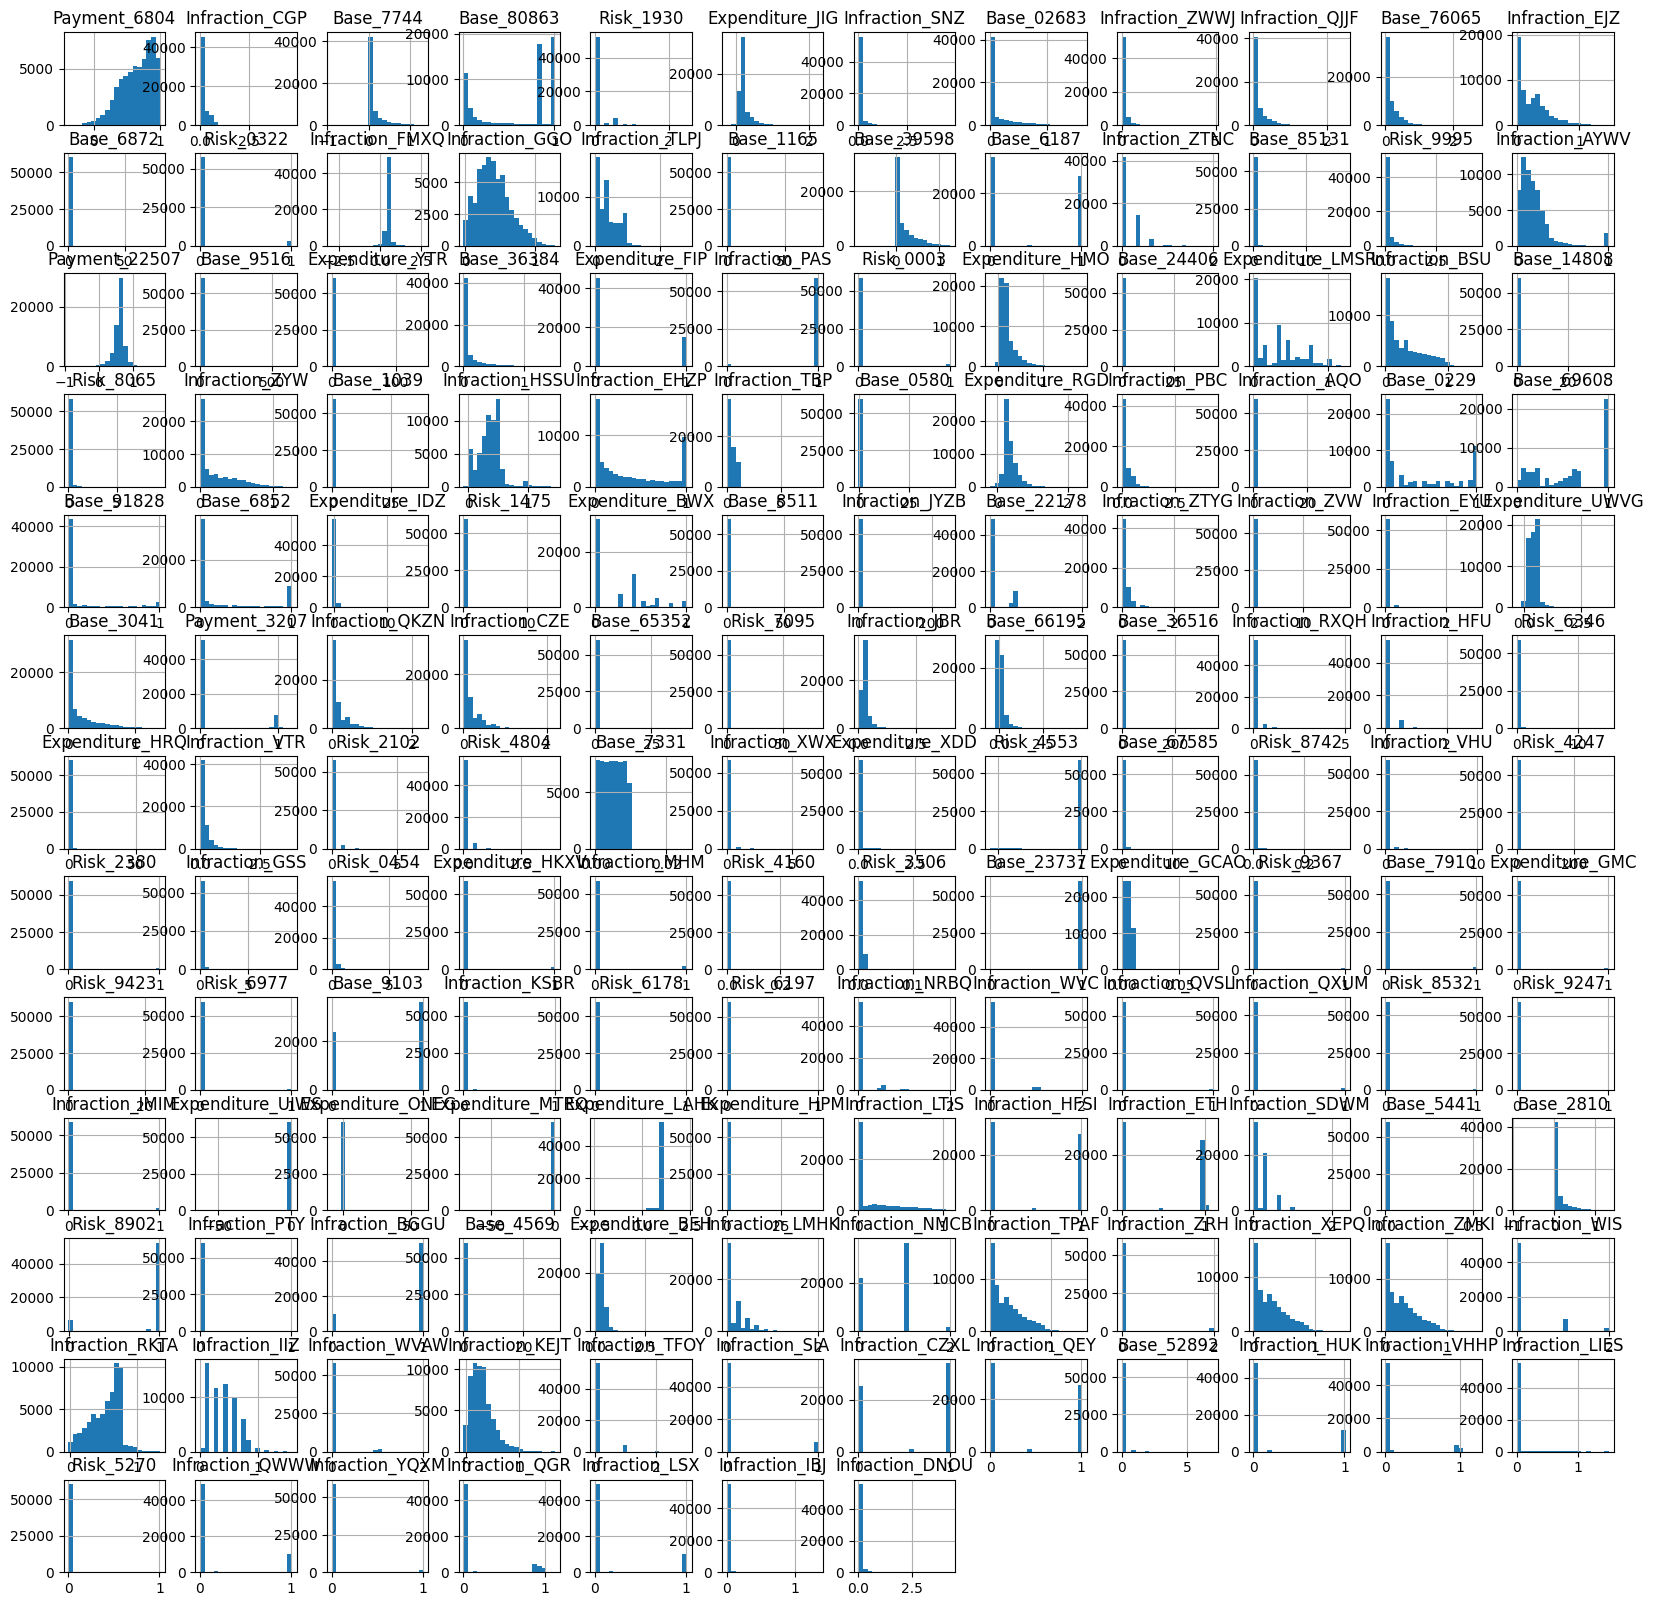

In [21]:
# Selecciona solo las columnas numéricas
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns

# Graficar histogramas en un grid
df[numeric_columns].hist(figsize=(20, 20), bins=20)
plt.show()

# Detección de outliers

La investigación realizada sugiere las siguientes estrategias para identificar outliers:  

- **Método del Rango Intercuartílico (IQR):**  
  Ideal para distribuciones que no son normales y aplicable a cualquier tipo de distribución, ya que se basa en la posición relativa de los datos en lugar de asumir una forma específica.  

- **Z-score:**  
  Útil para detectar outliers en datos con una distribución aproximadamente normal o cuando no es posible determinar la distribución con precisión. Este método evalúa qué tan alejados están los valores en términos de desviaciones estándar de la media.

Dado que, como se observó en la visualización previa de las distribuciones, las variables numéricas no presentan generalmente una distribución normal, se opta por utilizar el método **IQR** para la detección de outliers.  

In [22]:
# Calcular el primer y tercer cuartil
Q1 = df[numeric_columns].quantile(0.25)
Q3 = df[numeric_columns].quantile(0.75)
IQR = Q3 - Q1

# Identificar outliers como valores fuera de 1.5 veces el IQR
outliers_iqr = ((df[numeric_columns] < (Q1 - 1.5 * IQR)) | (df[numeric_columns] > (Q3 + 1.5 * IQR)))

# Contar el número de outliers por columna
outliers_count_iqr = outliers_iqr.sum(axis=0)
# mostrar todos los registros
pd.options.display.max_rows = None
print("Número de outliers por columna (IQR):\n", outliers_count_iqr)

Número de outliers por columna (IQR):
 Payment_6804          236
Infraction_CGP       6013
Base_7744            7922
Base_80863              0
Risk_1930            7942
Expenditure_JIG     10374
Infraction_SNZ       7669
Base_02683           7733
Infraction_ZWWJ      7295
Infraction_QJJF      7632
Base_76065           3734
Infraction_EJZ       1608
Base_6872            8572
Risk_0322            2731
Infraction_FMXQ     10911
Infraction_GGO        424
Infraction_TLPJ        34
Base_1165            1914
Base_39598           4058
Base_6187               0
Infraction_ZTNC      1173
Base_85131            892
Risk_9995            3438
Infraction_AYWV      2803
Payment_22507        5523
Base_9516             856
Expenditure_YTR      7716
Base_36384           8608
Expenditure_FIP     15031
Infraction_PAS       1319
Risk_0003            1732
Expenditure_HMO      5166
Base_24406           7509
Expenditure_LMSR       32
Infraction_BSU         26
Base_14808           5993
Risk_8065            1896

# Tratamiento de outliers

De acuerdo con la investigación, es crucial tratar los outliers antes de normalizar o estandarizar los datos. Esto se debe a que los valores extremos pueden distorsionar significativamente estos procesos, afectando tanto la distribución de los datos como el rendimiento de los modelos posteriores.

Se ha optado por el cálculo del porcentaje de outliers en cada columna utilizando el método del **Rango Intercuartílico (IQR)**, que identifica valores que están por encima de 1.5 veces el IQR desde el primer y tercer cuartil. Este enfoque es especialmente efectivo para datos con distribuciones no normales.

### Estrategias para el tratamiento de outliers según su proporción:

1. **Columnas con menos del 5% de outliers:**  
   - **Estrategia:** Eliminación de los outliers.  
   - **Justificación:** Representan una pequeña proporción de los datos, por lo que su eliminación tiene un impacto mínimo en la cantidad total de información. Los valores extremos en estas columnas probablemente no aportan patrones relevantes, y su eliminación mejora la calidad del dataset sin pérdida significativa de información.

2. **Columnas con entre el 5% y el 15% de outliers:**  
   - **Estrategia:** Reemplazo de los outliers con los límites del IQR (mínimo o máximo permitido por el rango intercuartílico).  
   - **Justificación:** Eliminar este porcentaje de outliers podría llevar a una pérdida considerable de datos. Reemplazarlos suaviza su impacto, manteniendo todas las filas en el dataset y reduciendo la influencia de los valores extremos sin eliminarlos.

3. **Columnas con más del 15% de outliers:**  
   - **Estrategia:** Aplicación de transformaciones logarítmicas o de raíz cuadrada.  
   - **Justificación:** Dado que más del 15% de los datos contienen valores extremos, eliminarlos o reemplazarlos podría alterar sustancialmente la estructura de los datos y posiblemente eliminar patrones importantes.  
     - **Transformación logarítmica:** Útil para datos con crecimiento exponencial o gran variabilidad, ya que comprime los valores extremos.  
     - **Transformación de raíz cuadrada:** Suaviza la dispersión sin comprimir tanto como el logaritmo, siendo ideal para datos con variabilidad moderada.


In [23]:
# Número total de filas
total_rows = len(df)

# Calcular el porcentaje de outliers en cada columna
outliers_percentage = (outliers_count_iqr / total_rows) * 100
# mostrar todos los registros
pd.options.display.max_rows = None
print("Porcentaje de outliers por columna (IQR):\n", outliers_percentage)

Porcentaje de outliers por columna (IQR):
 Payment_6804         0.391331
Infraction_CGP       9.970650
Base_7744           13.136120
Base_80863           0.000000
Risk_1930           13.169284
Expenditure_JIG     17.201983
Infraction_SNZ      12.716600
Base_02683          12.822724
Infraction_ZWWJ     12.096440
Infraction_QJJF     12.655247
Base_76065           6.191653
Infraction_EJZ       2.666357
Base_6872           14.213939
Risk_0322            4.528496
Infraction_FMXQ     18.092427
Infraction_GGO       0.703069
Infraction_TLPJ      0.056378
Base_1165            3.173761
Base_39598           6.728904
Base_6187            0.000000
Infraction_ZTNC      1.945048
Base_85131           1.479099
Risk_9995            5.700831
Infraction_AYWV      4.647885
Payment_22507        9.158141
Base_9516            1.419404
Expenditure_YTR     12.794535
Base_36384          14.273633
Expenditure_FIP     24.924138
Infraction_PAS       2.187142
Risk_0003            2.871972
Expenditure_HMO      8.5661

# Tratamiento de outliers

De acuerdo con la investigación, es crucial tratar los outliers antes de normalizar o estandarizar los datos. Esto se debe a que los valores extremos pueden distorsionar significativamente estos procesos, afectando tanto la distribución de los datos como el rendimiento de los modelos posteriores.

Se ha optado por el cálculo del porcentaje de outliers en cada columna utilizando el método del **Rango Intercuartílico (IQR)**, que identifica valores que están por encima de 1.5 veces el IQR desde el primer y tercer cuartil. Este enfoque es especialmente efectivo para datos con distribuciones no normales.

### Estrategias para el tratamiento de outliers según su proporción:

1. **Columnas con menos del 5% de outliers:**  
   - **Estrategia:** Eliminación de los outliers.  
   - **Justificación:** Representan una pequeña proporción de los datos, por lo que su eliminación tiene un impacto mínimo en la cantidad total de información. Los valores extremos en estas columnas probablemente no aportan patrones relevantes, y su eliminación mejora la calidad del dataset sin pérdida significativa de información.

2. **Columnas con entre el 5% y el 15% de outliers:**  
   - **Estrategia:** Reemplazo de los outliers con los límites del IQR (mínimo o máximo permitido por el rango intercuartílico).  
   - **Justificación:** Eliminar este porcentaje de outliers podría llevar a una pérdida considerable de datos. Reemplazarlos suaviza su impacto, manteniendo todas las filas en el dataset y reduciendo la influencia de los valores extremos sin eliminarlos.

3. **Columnas con más del 15% de outliers:**  
   - **Estrategia:** Aplicación de transformaciones logarítmicas o de raíz cuadrada.  
   - **Justificación:** Dado que más del 15% de los datos contienen valores extremos, eliminarlos o reemplazarlos podría alterar sustancialmente la estructura de los datos y posiblemente eliminar patrones importantes.  
     - **Transformación logarítmica:** Útil para datos con crecimiento exponencial o gran variabilidad, ya que comprime los valores extremos.  
     - **Transformación de raíz cuadrada:** Suaviza la dispersión sin comprimir tanto como el logaritmo, siendo ideal para datos con variabilidad moderada.


In [24]:
# Filtrar las columnas con menos del 5% de outliers
# Esto selecciona las columnas en las que el porcentaje de outliers es menor al 5%
# Utilizamos 'outliers_percentage' para identificar estas columnas y obtener sus nombres
minor_outlier_columns = outliers_percentage[outliers_percentage < 5].index

# Filtrar filas eliminando los outliers en estas columnas
# Recorremos cada columna en 'minor_outlier_columns' para identificar y eliminar los outliers en esas columnas
for col in minor_outlier_columns:

    # Calculamos el límite inferior de IQR para la columna actual
    # Este límite inferior se define como Q1 - 1.5 * IQR, y cualquier valor por debajo de este se considera un outlier
    lower_limit = Q1[col] - 1.5 * IQR[col]

    # Calculamos el límite superior de IQR para la columna actual
    # Este límite superior se define como Q3 + 1.5 * IQR, y cualquier valor por encima de este se considera un outlier
    upper_limit = Q3[col] + 1.5 * IQR[col]

    # Filtramos el dataframe eliminando las filas con outliers en la columna actual
    # Solo mantenemos las filas donde el valor en la columna está entre el límite inferior y el límite superior
    # Esto elimina todas las filas que contienen valores fuera de los límites permitidos
    df = df[(df[col] >= lower_limit) & (df[col] <= upper_limit)]


In [25]:
import numpy as np

# Filtrar las columnas con entre 5% y 15% de outliers
# Esto selecciona las columnas donde el porcentaje de outliers está entre el 5% y el 15%
# Utilizamos los valores en 'outliers_percentage' para crear una lista con los nombres de estas columnas
moderate_outlier_columns = outliers_percentage[(outliers_percentage >= 5) & (outliers_percentage <= 15)].index

# Reemplazar los outliers en estas columnas con los límites de IQR
# Recorremos cada columna en 'moderate_outlier_columns' para aplicar el reemplazo de outliers
for col in moderate_outlier_columns:

    # Calculamos el límite inferior de IQR para la columna actual
    # Este límite inferior es Q1 - 1.5 * IQR y representa el valor más bajo permitido sin considerar outlier
    lower_limit = Q1[col] - 1.5 * IQR[col]

    # Calculamos el límite superior de IQR para la columna actual
    # Este límite superior es Q3 + 1.5 * IQR y representa el valor más alto permitido sin considerar outlier
    upper_limit = Q3[col] + 1.5 * IQR[col]

    # Usamos np.where para reemplazar los valores fuera de los límites en la columna actual
    # Si el valor es menor que el límite inferior, lo reemplaza con 'lower_limit'
    # Si el valor es mayor que el límite superior, lo reemplaza con 'upper_limit'
    # De lo contrario, mantiene el valor original
    df[col] = np.where(df[col] < lower_limit, lower_limit,
                       np.where(df[col] > upper_limit, upper_limit, df[col]))


In [26]:
# Filtrar las columnas con más del 15% de outliers
high_outlier_columns = outliers_percentage[outliers_percentage > 15].index

# Decidir transformación basada en skewness y kurtosis
for col in high_outlier_columns:
    original_skew = skew(df[col].dropna())
    log_skew = skew(np.log1p(df[col].dropna()))
    sqrt_skew = skew(np.sqrt(df[col].dropna().clip(lower=0)))

    print(f'Columna: {col}')
    print(f'  Skew original: {original_skew}')
    print(f'  Skew logaritmo: {log_skew}')
    print(f'  Skew raíz cuadrada: {sqrt_skew}')

    if abs(log_skew) < abs(sqrt_skew):
        print(f'  Transformación recomendada: Logaritmo')
    else:
        print(f'  Transformación recomendada: Raíz Cuadrada')


Columna: Expenditure_JIG
  Skew original: 3.4454546627335385
  Skew logaritmo: 2.5835853151445503
  Skew raíz cuadrada: 1.465688765509019
  Transformación recomendada: Raíz Cuadrada
Columna: Infraction_FMXQ
  Skew original: -1.237918231520924
  Skew logaritmo: nan
  Skew raíz cuadrada: -2.615404187465512
  Transformación recomendada: Raíz Cuadrada
Columna: Expenditure_FIP
  Skew original: 0.9030839012674448
  Skew logaritmo: 0.9029639859752144
  Skew raíz cuadrada: 0.8958948725295884
  Transformación recomendada: Raíz Cuadrada
Columna: Base_0580
  Skew original: 17.223186950946328
  Skew logaritmo: 8.023640261197931
  Skew raíz cuadrada: 5.195415588423732
  Transformación recomendada: Raíz Cuadrada
Columna: Base_91828
  Skew original: 2.42899621154896
  Skew logaritmo: 2.2425299816931537
  Skew raíz cuadrada: 1.9259918779689988
  Transformación recomendada: Raíz Cuadrada
Columna: Base_6852
  Skew original: 1.8923357467249136
  Skew logaritmo: 1.7583810096303198
  Skew raíz cuadrada: 1.

In [27]:
# Columnas recomendadas para raíz cuadrada
sqrt_columns = [
    'Risk_1930', 'Infraction_SNZ', 'Infraction_QJJF', 'Infraction_FMXQ',
    'Expenditure_FIP', 'Base_0580', 'Base_91828', 'Expenditure_IDZ',
    'Base_22178', 'Infraction_ZVW', 'Infraction_JBR', 'Expenditure_UIWS',
    'Expenditure_MTRQ', 'Expenditure_HPM', 'Infraction_HUK', 'Infraction_QWWW',
    'Infraction_QGR', 'Infraction_LSX', 'Infraction_DNOU'
]

# Columnas recomendadas para logaritmo
log_columns = ['Infraction_BGGU']

# Aplicar transformaciones Raíz cuadrada
for col in sqrt_columns:
    df[col] = np.sqrt(df[col].clip(lower=0))  # Asegura que no haya valores negativos

# Aplicar transformaciones Logaritmo
for col in log_columns:
    df[col] = np.log1p(df[col].clip(lower=0))  # log1p(x) es log(1 + x) y evita problemas con ceros

Aquí tienes una versión mejorada de tu comentario:

---

# División de los Datos en Variables Predictoras (X) y Variable Objetivo (y)

En este paso, se separan las variables predictoras (`X`) de la variable objetivo (`y`) para preparar los datos para el modelado. Antes de la separación, se realizan las siguientes transformaciones:

1. **Conversión de columnas categóricas:**  
   - Las columnas `Infraction_NMCB`, `Infraction_ZRH` e `Infraction_WIS` se convierten de tipo `int` a `category`.  
   - **Justificación:** Estas columnas contienen valores como `0`, `1`, y `2`, que representan categorías en lugar de valores numéricos. Realizar esta conversión evita que se traten como números enteros, asegurando una interpretación adecuada.

2. **Conversión de columnas booleanas:**  
   - Las columnas de tipo `bool` se convierten a `int`.  
   - **Justificación:** Esto garantiza la compatibilidad con modelos de machine learning que no soportan directamente datos booleanos, representando `True` como `1` y `False` como `0`.

3. **Eliminación de columnas sin variabilidad:**  
   - Se elimina la columna `Base_23737` porque tiene un único valor (`1`) en todas las filas.  
   - **Justificación:** Una columna sin variabilidad no aporta información útil al modelo y solo añade ruido innecesario al dataset.

4. **Eliminación de la columna de fecha:**  
   - Se elimina la columna `fecha`, ya que no parece contener información significativa para el problema.  
   - **Justificación:** Parece ser únicamente una marca temporal y no tiene relación directa con la variable objetivo, por lo que no contribuye al proceso de predicción.

**Resultado:**  
Los datos están ahora listos, con las variables predictoras y la variable objetivo separadas, optimizadas para el análisis y el entrenamiento del modelo.  


In [28]:
df.dtypes

,0
Expenditure_AHF,datetime64[ns]
Payment_6804,float64
Infraction_CGP,float64
Base_7744,float64
Base_80863,float64
Risk_1930,float64
Expenditure_JIG,float64
Infraction_SNZ,float64
Base_02683,float64
Infraction_ZWWJ,float64


In [29]:
df.Infraction_WIS.unique()
df.Infraction_ZRH.unique()
df.Infraction_NMCB.unique()
df.Base_23737.unique()

array([1])

In [30]:
# Convertir columnas categóricas con valores int a category
categorical_int_columns = ['Infraction_NMCB', 'Infraction_ZRH', 'Infraction_WIS']
for col in categorical_int_columns:
    df[col] = df[col].astype('category')

# Convertir columnas booleanas a int
boolean_columns = df.select_dtypes(include=['bool']).columns
df[boolean_columns] = df[boolean_columns].astype(int)

# Eliminar columnas constantes (si es el caso)
df = df.drop(columns=['Expenditure_AHF','Base_23737'])

In [31]:
df.dtypes

,0
Payment_6804,float64
Infraction_CGP,float64
Base_7744,float64
Base_80863,float64
Risk_1930,float64
Expenditure_JIG,float64
Infraction_SNZ,float64
Base_02683,float64
Infraction_ZWWJ,float64
Infraction_QJJF,float64


In [32]:
df.isnull().sum()

,0
Payment_6804,0
Infraction_CGP,0
Base_7744,0
Base_80863,0
Risk_1930,0
Expenditure_JIG,0
Infraction_SNZ,0
Base_02683,0
Infraction_ZWWJ,0
Infraction_QJJF,0


# Creación del DataFrame con las Columnas Seleccionadas por RFE (Selección de Características)

En este paso, se genera un nuevo DataFrame que contiene únicamente las columnas seleccionadas mediante el método de **Recursive Feature Elimination (RFE)**.  

**Objetivo:**  
Optimizar el dataset seleccionando las características más relevantes para el modelo, según su importancia determinada por RFE. Esto ayuda a reducir la dimensionalidad, eliminar ruido y mejorar el desempeño del modelo.

**Proceso:**  
1. Se identifican las columnas seleccionadas como las más influyentes por el proceso de RFE.  
2. Se crea un nuevo DataFrame que incluye únicamente estas columnas seleccionadas.  
3. El DataFrame resultante sirve como base para entrenar modelos con un conjunto reducido de características clave.  

**Resultado:**  
Un DataFrame optimizado con las características seleccionadas por RFE, diseñado para maximizar la eficiencia y precisión del modelo.  


In [33]:
rfe_columns = ['Payment_6804', 'Base_80863', 'Expenditure_JIG', 'Base_02683',
       'Infraction_ZWWJ', 'Infraction_QJJF', 'Infraction_EJZ',
       'Infraction_GGO', 'Infraction_TLPJ', 'Base_1165', 'Base_39598',
       'Base_6187', 'Base_85131', 'Risk_9995', 'Infraction_AYWV', 'Base_9516',
       'Expenditure_HMO', 'Infraction_BSU', 'Infraction_ZYW', 'Infraction_TBP',
       'Infraction_PBC', 'Base_0229', 'Base_69608', 'Base_3041',
       'Infraction_QKZN', 'Infraction_CZE', 'Expenditure_MTRQ',
       'Infraction_XEPQ', 'Infraction_RKTA', 'Infraction_KEJT']

In [34]:
df_rfe = df[rfe_columns].copy()
df_rfe.head()

,Payment_6804,Base_80863,Expenditure_JIG,Base_02683,Infraction_ZWWJ,Infraction_QJJF,Infraction_EJZ,Infraction_GGO,Infraction_TLPJ,Base_1165,Base_39598,Base_6187,Base_85131,Risk_9995,Infraction_AYWV,Base_9516,Expenditure_HMO,Infraction_BSU,Infraction_ZYW,Infraction_TBP,Infraction_PBC,Base_0229,Base_69608,Base_3041,Infraction_QKZN,Infraction_CZE,Expenditure_MTRQ,Infraction_XEPQ,Infraction_RKTA,Infraction_KEJT
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3333128835400580213056325007513731082455233755300853872133001501,0.876615,0.810796,0.164262,0.004826,0.089624,0.040931,0.222406,0.318290,0.081635,0.168822,0.029138,0.004512,0.003663,0.007835,0.200082,0.222126,0.139936,0.073229,0.079300,0.050804,0.435111,0.089827,0.694587,0.022871,0.080399,0.075688,0.293262,0.346611,0.419969,0.278417
3333128835400580213056325007513731082455233755300853872133001501,0.887385,0.819078,0.164262,0.007282,0.089624,0.085550,0.229166,0.319989,0.038728,0.163958,0.042446,0.005438,0.001267,0.002711,0.203012,0.168061,0.139936,0.057529,0.093492,0.174204,0.435475,0.009776,0.694218,0.030503,0.071439,0.075889,0.285643,0.349924,0.428385,0.278974
3333128835400580213056325007513731082455233755300853872133001501,0.884522,0.818569,0.164262,0.000859,0.089624,0.068582,0.229235,0.325441,0.042652,0.179561,0.041345,0.004756,0.007432,0.006428,0.201147,0.162125,0.139936,0.058096,0.093983,0.167016,0.432850,0.009382,0.689252,0.028021,0.072995,0.070007,0.287306,0.351911,0.427117,0.278597
3333128835400580213056325007513731082455233755300853872133001501,0.852514,0.819987,0.164262,0.007532,0.089624,0.067608,0.225778,0.323865,0.099060,0.181541,0.027656,0.007766,0.009521,0.003475,0.199916,0.302099,0.139936,0.071009,0.009662,0.092078,0.433641,0.006241,1.006410,0.016370,0.000284,0.006551,0.282256,0.345798,0.425334,0.274238
3333128835400580213056325007513731082455233755300853872133001501,0.891656,0.811041,0.164262,0.000626,0.089624,0.092528,0.231703,0.322895,0.072124,0.213943,0.031651,0.004834,0.002756,0.004604,0.198395,0.301122,0.139936,0.071812,0.001232,0.098001,0.436733,0.007604,1.004019,0.024234,0.002590,0.006040,0.293816,0.345541,0.426774,0.275148


In [35]:
df_rfe.to_csv('processed_dataset.csv')

# Escalado de Datos y Predicción

En este paso, se realiza el escalado de los datos seguido por el proceso de predicción utilizando el modelo seleccionado.  

**1. Escalado de los datos:**  
- Se aplica escalado a las variables numéricas para garantizar que todas las características tengan la misma escala, evitando que las diferencias en las magnitudes afecten el desempeño del modelo.  
- El escalado se realiza únicamente en el conjunto de entrenamiento, aplicando luego la misma transformación al conjunto de prueba para evitar fugas de información.

**2. Proceso de predicción:**  
- Se utiliza el modelo previamente entrenado para realizar predicciones en el conjunto de prueba.  
- Los resultados se almacenan y se preparan para su posterior análisis y evaluación.  

**Importancia:**  
Este paso asegura que los datos estén correctamente preprocesados y listos para la predicción, mejorando la estabilidad y precisión del modelo al trabajar con datos escalados.


In [37]:
import joblib

# Cargar el scaler y el modelo
scaler = joblib.load("scaler.joblib")
knn_model = joblib.load("knn_model.joblib")

# Separar características en df_rfe (sin la columna 'label' si ya existe)
X_rfe = df_rfe.drop(columns=['label'], errors='ignore')

# Escalar los datos de df_rfe usando el scaler cargado
X_rfe_scaled = scaler.transform(X_rfe)

# Realizar predicciones con el modelo k-NN
predictions = knn_model.predict(X_rfe_scaled)

# Agregar las predicciones como nueva columna 'label' en df_rfe
df_rfe['label'] = predictions

print("Predicciones añadidas al DataFrame `df_rfe`.")


Predicciones añadidas al DataFrame `df_rfe`.


In [38]:
df_rfe.label.value_counts()

,count
label,
0,21766
1,7280


In [39]:
df_rfe = df_rfe.reset_index()
df_rfe_final = df_rfe[['ID','label']]
df_rfe_final.head()

,ID,label
0,3333128835400580213056325007513731082455233755...,0
1,3333128835400580213056325007513731082455233755...,0
2,3333128835400580213056325007513731082455233755...,0
3,3333128835400580213056325007513731082455233755...,0
4,3333128835400580213056325007513731082455233755...,0


In [40]:
df_rfe_final.to_csv('test_labels.csv')